Will investigate the following 2 reviewer comments here:
(1) Is it possible to optimize the geometry? Or transition states and reaction paths? Perhaps this is the next step, but it would be essential to map out how strong coupling affects chemistry. For the Mg-Br system, is there an effect of the strong coupling on the ground state equilibrium?

(2) Somewhat related to my previous comments on the field strength: The diffference between the simple Jaynes-Cummings-like model (eq. 22) and the CQED-CIS method is very interesting to see, but how strong does the field need to be in order to see these differences. Might it be that for moderate fields, which may be more in line with experiment, in particular for optical cavities, the differences would dissappear?
Still needs to be addressed.



In [56]:
from __future__ import print_function

"""
A script to run the cqed_rhf and cqed_cis method on MgH+ potential energy surface in a cc-pVDZ basis set,
reproducing data from Figure 3 by McTague and Foley.
"""

__authors__   = ["Jon McTague", "Jonathan Foley"]
__credits__   = ["Jon McTague", "Jonathan Foley"]

__copyright_amp__ = "(c) 2014-2018, The Psi4NumPy Developers"
__license__   = "BSD-3-Clause"
__date__      = "2021-01-15"

# ==> Import Psi4, NumPy, & SciPy <==
import psi4
import numpy as np
from helper_cqed_rhf import *
from helper_cis import *
from helper_cs_cqed_cis import *
from psi4.driver.procrouting.response.scf_response import tdscf_excitations
from matplotlib import pyplot as plt
# Set Psi4 & NumPy Memory Options
psi4.set_memory('2 GB')
psi4.core.set_output_file('output.dat', False)

numpy_memory = 2


Virtual photons in the resonant Lorentz model. a Number of photons in the resonant mode ck = ω 0 as a function of the coupling for γ L = 0 (thin blue line), 0.5ω 0 (solid cyan line), ω 0 (dash-dotted green line), 1.5ω 0 (dashed magenta line) and 2ω 0 (dotted red line)

We will explore the photon occupation in the ground state under different cavity coupling
and dissipation rates.  In particular, we will consider cavity coupling strengths $g$ relative 
to the photon energy / transition energy as follows:

$$ g = N\frac{\omega}{2}, $$
where $N = 0.5, 1, 1.5, 2$.

We can estimate $g$ as 

$$ g = \sqrt{\frac{\omega}{2}}\lambda \mu $$, 

where we can rearrange for $\lambda$:

$$ \lambda = \frac{f}{\mu \sqrt{\frac{1}{2\omega}}} $$
where $f = 0.25, 0.5, 0.75, 1.0$.

Additionally, we will consider an imaginary part of the frequency $\gamma$ such 
that 
$$ \gamma = m \omega, $$
where $m = 0.0, 0.5, 1.0, 1.5, 2.0$.

In [57]:
# template for z-matrix
molstr = """
Mg
H 1 2.2
symmetry c1
1 1
"""

# options dict
options_dict = {'basis': 'cc-pVDZ',
               'save_jk': True, 
               'scf_type': 'pk'}

# set psi4 options
psi4.set_options(options_dict)

# approximate maximum value of transition dipole moment in a.u.
max_tdm = 2.25

# fix real part of omega
om_r = 4.75 / 27.211

# approximate max value of g
g_max = np.sqrt(om_r/2) * lam_z * max_tdm

# this is a list of fraction values that is used to compute the value
# of \lambda such that the g/\omega is a fraction with the following magnitudes
f_list = np.array([0., 0.25, 0.5, 0.75, 1.0])

# this is a list of fraction values that is used to define the \gamma value
# relative to the real part of the frequency \omega
m_list = np.array([0, 0.5, 1.0, 1.5, 2.0])

# photon energy
om_r = 4.75 / 27.211

# define the different values of \lambda
lambda_list = f_list / (max_tdm * np.sqrt(1/(2 * om_r)))
print("lambda list")
print(lambda_list)


# get in terms of g
g_list = np.sqrt(om_r/2) * lambda_list * max_tdm
print("g list")
print(g_list)

# define the different values of \gamma
gamma_list = om_r * m_list
print("gamma list")
print(gamma_list)

# array to hold the cs-cqed-cis energies
cqed_cis_energy_array = np.zeros((5, n_lam),dtype=complex)

# array to hold the photon occupations of the ground state
photon_occupation = np.zeros((len(m_list),len(f_list)))

# loop over the different bond-lengths, create different instances
# of MgH+ molecule and compute and store various quantities
n_state = 0
l_ctr = 0
mol = psi4.geometry(molstr)
e, wfn = psi4.energy("scf/cc-pVDZ", return_wfn=True, molecule=mol)
for l in lambda_list:
    lam = np.array([0, 0, l])
    #mol = psi4.geometry(molstr)
    #e, wfn = psi4.energy("scf/cc-pVDZ", return_wfn=True, molecule=mol)
    
    g_ctr = 0
    for g in gamma_list:
        om = om_r - g/2 * 1j
        cqed_dict = cs_cqed_cis(lam, om, molstr, options_dict)
        CL = cqed_dict['CQED-CIS L VECTORS']
        CR = cqed_dict['CQED-CIS R VECTORS'] 
        po = 0.0
        po = np.real(np.conj(CL[1,n_state]) * CR[1,n_state])
        #for i in range(0, len(CL[:,0])):
        #    if i%2==1:
        #        po += np.real(np.conj(CL[i,n_state]) * CR[i,n_state])
        photon_occupation[g_ctr, l_ctr] = po
        g_ctr += 1
    l_ctr += 1
    

    

 

lambda list
[0.         0.06565186 0.13130372 0.19695558 0.26260744]
g list
[0.         0.04364044 0.08728088 0.13092132 0.17456176]
gamma list
[0.         0.08728088 0.17456176 0.26184264 0.34912352]

Start SCF iterations:

Canonical RHF One-electron energy = -281.6658775695342456
CQED-RHF One-electron energy      = -281.6658775695342456
Nuclear repulsion energy          = 2.8864211491090908
Dipole energy                     = 0.0000000000000000
SCF Iteration   1: Energy = -199.8639591041890924   dE = -1.99864E+02   dRMS = 4.60183E-08
SCF Iteration   2: Energy = -199.8639591041913661   dE = -2.27374E-12   dRMS = 1.41134E-08
Total time for SCF iterations: 0.009 seconds 

QED-RHF   energy: -199.86395910 hartree
Psi4  SCF energy: -199.86395910 hartree

Start SCF iterations:

Canonical RHF One-electron energy = -281.6658775695342456
CQED-RHF One-electron energy      = -281.6658775695342456
Nuclear repulsion energy          = 2.8864211491090908
Dipole energy                     = 0.0000000


Start SCF iterations:

Canonical RHF One-electron energy = -281.6658775695342456
CQED-RHF One-electron energy      = -281.6823422633632390
Nuclear repulsion energy          = 2.8864211491090908
Dipole energy                     = 0.1044433899244761
SCF Iteration   1: Energy = -199.7945855025466528   dE = -1.99795E+02   dRMS = 2.78997E-03
SCF Iteration   2: Energy = -199.8050897843595237   dE = -1.05043E-02   dRMS = 6.78239E-04
SCF Iteration   3: Energy = -199.8055897255455307   dE = -4.99941E-04   dRMS = 2.13284E-04
SCF Iteration   4: Energy = -199.8056412598748182   dE = -5.15343E-05   dRMS = 8.23374E-05
SCF Iteration   5: Energy = -199.8056489139168548   dE = -7.65404E-06   dRMS = 3.60957E-05
SCF Iteration   6: Energy = -199.8056503774257919   dE = -1.46351E-06   dRMS = 1.71948E-05
SCF Iteration   7: Energy = -199.8056507009954998   dE = -3.23570E-07   dRMS = 8.45600E-06
SCF Iteration   8: Energy = -199.8056507773830219   dE = -7.63875E-08   dRMS = 4.19852E-06
Total time for SCF ite


Start SCF iterations:

Canonical RHF One-electron energy = -281.6658775695342456
CQED-RHF One-electron energy      = -281.7029231306497081
Nuclear repulsion energy          = 2.8864211491090908
Dipole energy                     = 0.2349976273300713
SCF Iteration   1: Energy = -199.7078685004939018   dE = -1.99708E+02   dRMS = 6.27742E-03
SCF Iteration   2: Energy = -199.7452532009680510   dE = -3.73847E-02   dRMS = 1.92753E-03
SCF Iteration   3: Energy = -199.7472359926696299   dE = -1.98279E-03   dRMS = 5.53628E-04
SCF Iteration   4: Energy = -199.7474765118709570   dE = -2.40519E-04   dRMS = 2.64664E-04
SCF Iteration   5: Energy = -199.7475276048412525   dE = -5.10930E-05   dRMS = 1.31838E-04
SCF Iteration   6: Energy = -199.7475443533619170   dE = -1.67485E-05   dRMS = 8.62323E-05
SCF Iteration   7: Energy = -199.7475509704294723   dE = -6.61707E-06   dRMS = 5.46641E-05
SCF Iteration   8: Energy = -199.7475537409976312   dE = -2.77057E-06   dRMS = 3.62892E-05
SCF Iteration   9: Ene


Start SCF iterations:

Canonical RHF One-electron energy = -281.6658775695342456
CQED-RHF One-electron energy      = -281.7317363448509582
Nuclear repulsion energy          = 2.8864211491090908
Dipole energy                     = 0.4177735596979045
SCF Iteration   1: Energy = -199.5864646976201868   dE = -1.99586E+02   dRMS = 1.11598E-02
SCF Iteration   2: Energy = -199.6634827221976138   dE = -7.70180E-02   dRMS = 5.63338E-03
SCF Iteration   3: Energy = -199.6732446257263973   dE = -9.76190E-03   dRMS = 2.59422E-03
SCF Iteration   4: Energy = -199.6752809104952178   dE = -2.03628E-03   dRMS = 1.47326E-03
SCF Iteration   5: Energy = -199.6758651847131603   dE = -5.84274E-04   dRMS = 7.91243E-04
SCF Iteration   6: Energy = -199.6760689925305314   dE = -2.03808E-04   dRMS = 4.86700E-04
SCF Iteration   7: Energy = -199.6761529850295176   dE = -8.39925E-05   dRMS = 2.87593E-04
SCF Iteration   8: Energy = -199.6761927791635003   dE = -3.97941E-05   dRMS = 1.99632E-04
SCF Iteration   9: Ene

No handles with labels found to put in legend.


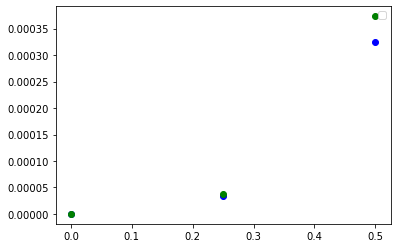

In [58]:


plt.plot(g_list[:3]/om_r, photon_occupation[0,0:3], 'bo')
plt.plot(g_list[:3]/om_r, photon_occupation[3,0:3], 'go')
#plt.plot(g_list/om_r, photon_occupation[2,:], 'ro')
#plt.plot(g_list/om_r, photon_occupation[3,:], 'o')
#plt.plot(g_list/om_r, photon_occupation[4,:], 'o')
plt.legend()
plt.show()

In [ ]:
f = open('MgH_ccpVDZ_Ez_12.5mH_om_4.75_0g.txt', 'w')
stri = "radius; CIS X,1; CIS A,0; JC LP; JC UP; PF LP; PF UP; CQED-CIS LP; CQED-CIS UP"
f.write(" %s \n" % stri)
ctr=0
for r in r_array:
    f.write("%6.3f %12.6f %12.6f %12.6f %12.6f %12.6f %12.6f %12.6f %12.6f \n" % 
            (r, cis_energy_array[0,ctr]+np.real(om), cis_energy_array[1,ctr], 
            np.real(jc[0,ctr]),np.real(jc[1,ctr]), 
            np.real(pf[1,ctr]),np.real(pf[2,ctr]),
            np.real(cqed_cis_energy_array[1,ctr]),np.real(cqed_cis_energy_array[2,ctr])))
    ctr += 1
    
f.close()

Run the cell below to compute the data for Figure 2: scan of ground-state energy
of MgH+ coupled to a photon with energy 4.75 eV and lambda = 0.075 atomic units polarized along z
at the RHF/cc-pVDZ, CQED-RHF/cc-pVDZ, and CQED-CIS/cc-pVDZ levels.

Write the data to a file!

In [ ]:
# plot the ground-state potential energy surfaces
plt.plot(r_array, gs_energy_array[0,:], label='RHF')
plt.plot(r_array, gs_energy_array[1,:], label='CQED-RHF')
plt.plot(r_array, gs_energy_array[2,:], label='CQED-CIS')
plt.legend()
plt.show()


In [ ]:
# write the data to file!
f = open('MgH_gs_lamz_7.5mH_om_4.75.txt', 'w')
stri = "r; rhf_e, cqed_rhf_e, cqed_cis_e"
f.write(" %s \n" % stri)
ctr=0
for r in r_array:
    f.write("%6.3f %12.6f %12.6f %12.6f \n" % 
            (r, gs_energy_array[0,ctr], gs_energy_array[1,ctr], gs_energy_array[1,ctr]+gs_energy_array[2,ctr]))
    ctr += 1
    
f.close()